<a href="https://colab.research.google.com/github/judex22/TextClassification_for_Fake_News_Detection/blob/main/Fake_News_Detection_Trigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Assignment 1 (40% of grade): Text classification for Fake News Detection (Trigram BOW)

This coursework will involve you implementing functions for a text classifier, which you will train to detect **fake news** in a corpus of approx. 10,000 statements, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

In [ ]:
!pip install nltk

In [ ]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\jude
[nltk_data]     sequeira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\jude
[nltk_data]     sequeira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\jude
[nltk_data]     sequeira\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\jude
[nltk_data]     sequeira\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path,encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))





def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))

    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))




# Question 1: Input and Basic preprocessing (10 marks)

In [ ]:
def convert_label(label):
    """Converts the multiple classes into two,
    making it a binary distinction between fake news and real."""
    #return label
    # Converting the multiclass labels to binary label
    labels_map = {
        'true': 'REAL',
        'mostly-true': 'REAL',
        'half-true': 'REAL',
        'false': 'FAKE',
        'barely-true': 'FAKE',
        'pants-fire': 'FAKE'
    }
    return labels_map[label]


def parse_data_line(data_line):

    # Should return a tuple of the label as just FAKE or REAL and the statement
    # e.g. (label, statement)
    l=data_line[1]


    if (l=="true")or(l=="mostly-true")or(l=="half-true")or(l=="false")or(l=="barely-true")or(l=="pants-fire"):
        Label=convert_label(l)
        sent=data_line[2]


    return (Label,sent)

In [ ]:
import string
import regex as re


# Input: a string of one statement
def pre_process(text):
    # Should return a list of tokens
    # DESCRIBE YOUR METHOD IN WORDS

    text=text.translate(str.maketrans('','',string.punctuation))
    tokens = re.split(r"\s+",text)
    tokens= [x.lower() for x in tokens]
    stop_words=set(stopwords.words("english"))
    tokens=[i for i in tokens if i not in stop_words]
    lemmatizer=WordNetLemmatizer()
    tokens=[lemmatizer.lemmatize(w,pos='v') for w in tokens]
    if False:

        print("Output after PreProcessing Tokens:\n",tokens)

    return tokens

# Question 2: Basic Feature Extraction (20 marks)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix

global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):



    # Should return a dictionary containing features as keys, and weights as values
    # DESCRIBE YOUR METHOD IN WORDS

    featureDict = {}  # Global feature dictionary maps from words/features to unique index
    i = 0 # index counter variable for the global feature dict


    """Convert word tokens into a feature vector dictionary of
    feature index keys and weight values.

    Update the featureVector if in training phase, i.e. where training=True.
    """

    featureVector = {}                       # local feature vector for this example (in dict form)

    def generate_N_grams(text,ngram):                #function to get N-gram tokens(in this case N=3 i:e Trigram)

        words=text
        temp=zip(*[words[i:] for i in range(0,ngram)])
        ans=[' '.join(ngram) for ngram in temp]

        return ans

    trigram_token=generate_N_grams(tokens,3)


    for w in trigram_token:

        # First add to the global feature dictionary, and give it a position
        # if in training
        try:
            # if the word w is in the dictionary,
            # then assign i to its value in the dictionary
            i = featureDict[w]
        except KeyError:
            # else if it's not in the dictionary,
            # it's a new feature in training, add new entry
            i = len(featureDict) + 1
            featureDict[w] = i


        # Add to local feature vector (as a dictionary entry with a weight)

        try:
            # if the word w is in the local feature vector (repeat word), add 1/n weight
            featureVector[i] += 1 #(1.0/len(words))
        except KeyError:
            # else if it's not in the local feature vector, create the entry with 1/n weight
            featureVector[i] = 1 #(1.0/len(words))

        if False:
            # example binary alternative to the above (just add it as 1 if present)
            if not i in featureVector.keys():
                featureVector[i] = 1
    print("Feature Dictionary of Trigram BOW model\n",featureDict)
    print("Feature Vector of Trigram BOW model\n",featureVector,"\n")

    return featureVector






In [ ]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

# Question 3: Cross-validation (20 marks)

In [ ]:
#solution
from sklearn import metrics
from sklearn.metrics import classification_report
from statistics import mean


def cross_validate(dataset, folds):

    train=dataset
    results =[]
    cv_results=[]
    cv=[]
    prec=[]
    rec=[]
    f1=[]



    fold_size = int(len(dataset)/folds) + 1

    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset


        k_test= train[i:fold_size+i]
        k_train= train[0:i]+train[fold_size+i: ]

        k_train_label=[]
        k_test_label=[]


        for j in range(0,len(k_test)):
            k_test_label.append(k_test[j][1])

        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE

        classifier = train_classifier(k_train)
        k_test_true = k_test_label                   # get the ground-truth labels from the data
        k_test_pred = predict_labels([x[0] for x in k_test], classifier)

        results = precision_recall_fscore_support(k_test_true, k_test_pred ,average= 'weighted' )
        cv.append(results)

        if True:
            print("Precision: %f\nRecall: %f\nF Score:%f \n" % results[:3])
            print("Classification Report on 10 fold CV Test Data:\n",classification_report(k_test_true, k_test_pred) ,"\n")


    for q in range(0,10):
        prec.append(cv[q][0])
        rec.append(cv[q][1])
        f1.append(cv[q][2])

    prec_avg=mean(prec)
    rec_avg=mean(rec)
    f1_avg=mean(f1)


    cv_results=[prec_avg,rec_avg,f1_avg]

    print("\n\n The Average of Precision Recall F1 score across all 10 folds of Cross Validation:")
    return cv_results

In [ ]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [ ]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'fake_news.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


In [ ]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 820
Training Classifier...
Precision: 0.551800
Recall: 0.586585
F Score:0.450469 

Classification Report on 10 fold CV Test Data:
               precision    recall  f1-score   support

        FAKE       0.50      0.02      0.05       339
        REAL       0.59      0.98      0.74       481

    accuracy                           0.59       820
   macro avg       0.54      0.50      0.39       820
weighted avg       0.55      0.59      0.45       820
 

Fold start on items 820 - 1640
Training Classifier...
Precision: 0.525058
Recall: 0.542683
F Score:0.438400 

Classification Report on 10 fold CV Test Data:
               precision    recall  f1-score   support

        FAKE       0.50      0.08      0.14       375
        REAL       0.55      0.93      0.69       445

    accuracy                           0.54       820
   macro avg       0.52      0.51      0.42       820
weighted avg       0.53      0.54      0.44       820
 

Fold start on items 1640 - 24

[0.5377572555125357, 0.5636074732668509, 0.4408244305497541]

# 4. Error Analysis (10 marks)

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

Fold start on items 0 - 820
Training Classifier...


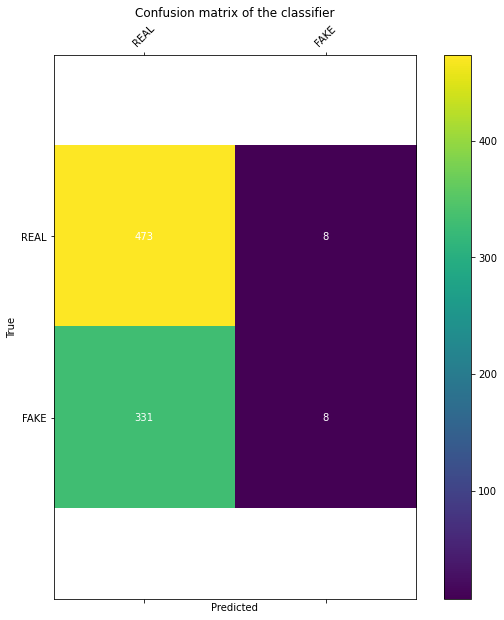

Accuracy of K-Fold Validation Data 0.5865853658536585


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
import statistics
r =[]

folds=10
fold_size = int(len(train_data)/folds) + 1
i=0




# confusion Matrix for first fold of 10 fold cross validation

k_test1= train_data[i:fold_size+i]
k_train1= train_data[0:i]+train_data[fold_size+i: ]

k_train_label1=[]
k_test_label1=[]


for j in range(0,len(k_test1)):
    k_test_label1.append(k_test1[j][1])

print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE

classifier1 = train_classifier(k_train1)
k_test_true1 = k_test_label1                   # get the ground-truth labels from the data
k_test_pred1 = predict_labels([x[0] for x in k_test1], classifier1)






labels=['REAL', 'FAKE']
confusion_matrix_heatmap(k_test_true1,k_test_pred1,labels)
print("Accuracy of K-Fold Validation Data",accuracy_score(k_test_true1,k_test_pred1))